# Opdracht Recurrent Neural Networks & Embedding

In [9]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re #regular expressions
np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

# Voor GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1. Opsporen van storingen

De opdracht bestaat erin een LSTM te trainen voor het voorspellen van storingen in motoren. Het bestand 'storingen.csv' bevat de data.
De dataset is tot stand gekomen door 100 motoren van hetzelfde type te bemeten en te tellen hoeveel cycli ze nog operationeel zijn vooraleer een storing zich manifesteert. 


De dataset is als volgt opgebouwd:
- engine_ID = Het ID een bepaalde motor.
- cycle = nummer van de cyclus van de motor.
- setting1, setting2, setting3 = de verschillende operationele modi.
- sensor1 -> sensor 21: metingen van de 21 verschillende sensoren.
- ttf = time to failure: hoeveel cycli de motor nog kan draaien vooraleer er een storing optreedt.


Een eerste benadering is het probleem te vereenvoudigen door het te vertalen naar een **classificatieprobleem**. Hierbij probeer je te voorspellen of de motor bijvoorbeeld binnen de komende 50 cycli al dan niet zal falen. 


De tweede benadering is het probleem beschouwen als een **regressieprobleem** waarbij je de resterende cycli (ttf) probeert te voorspellen.

### 1.1 Classificatie van de ttf

In [132]:
# Inladen van de training set

dataset = pd.read_csv('storingen.csv')
dataset.head()

,engine_id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


#### Preprocessing

Voeg een extra 'failure' kolom toe aan de dataset die weergeeft of de motor al dan niet binnen de 50 cycli zal falen. Met andere woorden: is de ttf groter dan 50 is de waarde 0, is de ttf kleiner of gelijk aan 50, dan is de waarde gelijk aan 1.

Bekijk ook in welke mate de data gebalanceerd is.


In [1]:
# Toevoegen van 'failure' kolom


In [2]:
# Gebalanceerdheid


#### Predictie op basis van enkelvoudige data samples (geheugenloos)

Vooraleer de data als tijdreeks te beschouwen en LSTM of GRU modellen te trainen is het interessant om eerst te bekijken hoe goed je kan voorspellen met modellen die de temporele component niet gebruiken en elke meting onafhankelijk van de vorige beschouwen.
Concreet betekent dit dat je voor een bepaald tijdstip op basis van de features de target probeert te voorspellen, zonder te kijken naar de voorgaande metingen. Elke rij in de dataset wordt onafhankelijk van de andere bekeken.

- Splits de dataset op in een training set en een test set. De eerste 75 motoren worden gebruikt om te trainen, de andere motoren om te testen.
- Train een logistic regression classifier en een random forest tree op de training set en evalueer met de test set. Bespreek de bekomen resultaten.
- Train een vanilla neuraal netwerk, waarmee een klassiek feedforward neuraal netwerk wordt bedoeld. Evalueer en bespreek.

In [3]:
# Opsplitsen in training set en test set



# Normalisatie van de training set en test set


# Logistic regression



# Random Forest Trees



# Vanilla neural network






#### Voorspelling op basis van time series data

Je kan vermoeden dat het al dan niet falen van de motoren binnen een zeker tijdinterval niet alleen bepaald wordt door de huidige meetwaarden maar voor een deel ook afgeleid kan worden uit het tijdsverloop van de meetwaarden.(=tijdreeks). Dit betekent dat de modellen rekening moeten houden met de huidige sample maar ook met een aantal voorgaande samples. Daarom zullen we onze toevlucht nemen tot recurrent neurals networks (LSTM of GRU) die via feedback verbindingen uitermate geschikt zijn om tijdsafhankelijkheden in time series te capteren.


Doorloop de volgende stappen:

- Opbouwen van de training set en test set:

De training set en test set zullen hier bestaan uit sequenties met zekere lengte (seq_length). Neem om te starten een seq_length=30. Om deze sequenties op te bouwen ga je als volgt te werk:
Overloop per engine_id de tijdreeks met een sliding window. Het window start bij de rij met de hoogste ttf en schuift rij per rij verder tot de motor faalt (laatste meting van die motor). De features die telkens binnen het window vallen vormen een sequentie (van in dit geval 30 waarden). Dit zijn de meest recente meetwaarde samen met 29 voorgaande meetwaarden. Bij de start zijn er nog geen voorgaande waarden, vandaar dat zero padding toegepast kan worden om toch tot een sequentie van 30 te komen. De bij een sequentie horende target waarde is de 'failure' waarde die hoort bij de meest recente meetwaarden in de sequentie.

- Compileer een training set en een test set. 

De samples (=sequenties) afkomstig van de eerste 75 motoren komen in de training set, de resterende in de test set. 


- Normaliseer de training set en test set (bijvoorbeeld via een MinMAX scaler)


- Trainen van een LSTM netwerk

Train een LSTM op de training set en varieer de hyperparameters om een zo hoog mogelijke accuraatheid te bekomen. Mogelijke hyperparameters van het netwerk zijn de batch size, aantal layers, het aantal units per layer, dropout, recurrent dropout, optimizer, ...
Probeer eveneens een bidirectional LSTM. Bijvoorbeeld: model.add(Bidirectional(LSTM(64)))

- Evalueer het LSTM netwerk en vergelijk de accuracy met deze van de niet-temporele modellen.

- Optimaliseer het neuraal netwerk om het aantal false negatives te reduceren (een falen binnen de 50 cylussen dat niet ontdekt wordt)

- Onderzoek of je met langere of kortere sequenties betere resultaten behaalt. 






In [166]:
# Uitwerking LSTM



## 1.2 Regressie van de ttf

- In plaats van te voorspellen of de motor zal falen binnen 50 cycli, voorspel je nu het aantal resterende cycli. De target is nu de time to failure (ttf).
- Splits ook hier de dataset op in een training set en een test set. De data van de eerste 75 motoren wordt gebruikt om mee te trainen, de andere motoren om mee te testen.
- Train een lineair regressiemodel en een random forest regressor op de training set en evalueer met de test set. Bespreek de bekomen resultaten in termen van Mean Absolute Error (MAE) en de R²-score.
- Train vervolgens een LSTM. Dit is vergelijkbaar met wat je hebt gedaan bij classificatie. Let wel op dat je de juiste activatie- en loss functies gebruikt. Vergelijk de bekomen MAE en de R²-score met deze van de niet-temporele modellen.

In [4]:
# Uitwerking regressie van de ttf


# Normalisatie van de training set en test set



# Lineaire regressie


# Random forest regressor




In [5]:
# Predictie van de resterende cycli via LSTM



Maak op basis van de test set een histogram van de verschillen tussen de voorspelde ttf en de werkelijke ttf.
Wat kan je daaruit besluiten? Lijkt het model eerder een onderschatting of een overschatting te maken van de ttf?


In [6]:
# histogram van de error (y_pred - y_test)



### Uitbreiding: time series prediction met convolutional neural networks

Als uitbreiding kan je proberen om een convolutional neural network te trainen op de sequenties. Elke sequenties kan je zien als een 2D array, gelijkaardig aan een afbeelding. 
Het trainen zal dus gelijkaardig zijn aan wat je gedaan hebt bij classificatie van images, alleen is de afbeelding hier een sequentie van sensorwaarden en de klasse het al dan niet falen binnen 50 cycli.

Probeer ook het regressieprobleem uit via een convolutional neural network waarbij je de ttf voorspelt.


In [7]:
# Classificatie via een CNN



In [8]:
# Regressie via CNN



## 2. Text embedding met LSTM 

### 2.1 VOORBEELD: Auteursidentificatie

Het doel is om een LSTM/GRU netwerk te trainen zodat het in staat is de schrijver van een stukje tekst de identificeren
De data is te vinden in 'author_dataset.csv'.

In [3]:
# inlezen van de dataset

dataset = pd.read_csv('./author_dataset.csv')
dataset.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## Text preprocessing

Text tokenization:
- Maak een Keras tokenizer aan
- Train de tokenizer op de teksten: tokenizer.fit_on_texts(X), met X de teksten
- Converteer de teksten naar sequences: tokenizer.texts_to_sequences(X), met X de teksten

Voor meer informatie over de preprocessing: https://keras.io/preprocessing/sequence/

Niet alle teksten bevatten evenveel woorden. Dit resulteert in sequenties met verschillende lengte.
Om sequenties met dezelfde lengte te bekomen is het nodig om padding toe te passen. In het voorbeeld pad_sequences(sequences, maxlen=100 padding='post') zal de maximale lengte van de sequenties 100 woorden bedragen.

In [4]:
# Omzetten van de labels naar numerieke waarden

dataset['author'].replace({'MWS':0,'EAP':1,'HPL':2},inplace=True)

In [5]:
# Bepalen van de lengte van de langste tekst en van de kortste tekst

print('max',len(dataset.text.max()))
print('min',len(dataset.text.min()))

max 97
min 27


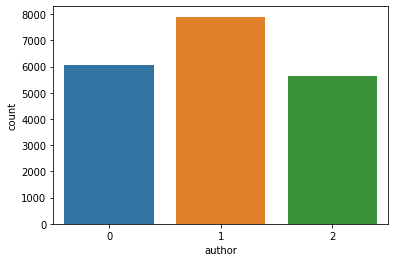

In [6]:
# Gebalanceerdheid van de dataset

g= dataset.groupby('author')
g.author.count()
sns.countplot(x='author',data=dataset)

In [7]:
# Splitsen in features en targets
X = dataset['text'].values
y = dataset['author'].values
# one-hot encoding van de labels
y = to_categorical(y)

In [8]:
# Sequenties genereren gebruik makende van de tokenizer
tokenizer = Tokenizer(num_words= None)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Voorbeeld van een sequentie
print(X[20])
print(sequences[20])

Now the net work was not permanently fastened to the hoop, but attached by a series of running loops or nooses.
[51, 1, 6598, 344, 8, 20, 8548, 2356, 4, 1, 4932, 19, 1949, 24, 5, 1525, 2, 2269, 6599, 35, 12285]


In [250]:
### Padding van de sequences (max_length = 100)
X_encoded = pad_sequences(sequences, maxlen=100, padding='post')

# Voorbeeld
X_encoded[20]

array([   51,     1,  6598,   344,     8,    20,  8548,  2356,     4,
           1,  4932,    19,  1949,    24,     5,  1525,     2,  2269,
        6599,    35, 12285,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [251]:
# Splitsen in training set en test set. Gebruik een test size = 3000 
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=3000, random_state=0,stratify = y)

Trainen van een LSTM/GRU met een embedding layer. 

Input -> Embedding layer -> LSTM -> Dense output layer(s)

In [255]:
vocabulary_size = X_train.max()

model = Sequential()
model.add(Embedding(vocabulary_size+1, 150, input_length=100))
model.add(SpatialDropout1D(0.3))
#model.add(LSTM(200,return_sequences=True))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10,verbose=1,batch_size=32, validation_split=0.2)

Train on 13263 samples, validate on 3316 samples
Epoch 1/10
13263/13263 [==============================] - 38s 3ms/sample - loss: 1.0893 - accuracy: 0.4029 - val_loss: 1.0883 - val_accuracy: 0.4035
Epoch 2/10
13263/13263 [==============================] - 37s 3ms/sample - loss: 1.0878 - accuracy: 0.4035 - val_loss: 1.0890 - val_accuracy: 0.4035
Epoch 3/10
13263/13263 [==============================] - 36s 3ms/sample - loss: 1.0880 - accuracy: 0.4041 - val_loss: 1.0879 - val_accuracy: 0.4029
Epoch 4/10
13263/13263 [==============================] - 38s 3ms/sample - loss: 1.0890 - accuracy: 0.4053 - val_loss: 1.0877 - val_accuracy: 0.4032
Epoch 5/10
13263/13263 [==============================] - 37s 3ms/sample - loss: 1.0852 - accuracy: 0.4057 - val_loss: 1.0877 - val_accuracy: 0.4032
Epoch 6/10
13263/13263 [==============================] - 37s 3ms/sample - loss: 1.0831 - accuracy: 0.4059 - val_loss: 1.0860 - val_accuracy: 0.4041
Epoch 7/10
13263/13263 [==============================] -

In [256]:
# Testen met de test set
y_pred = model.predict_classes(X_test)
y_true = np.argmax(y_test, axis=1)
print('\n')
print(accuracy_score(y_true, y_pred) * 100)
print('\n')
print(classification_report(y_true, y_pred))
print('\n')
cf = confusion_matrix(y_true, y_pred)
print(cf)



40.43333333333333


              precision    recall  f1-score   support

           0       0.75      0.00      0.01       926
           1       0.40      1.00      0.58      1211
           2       0.00      0.00      0.00       863

    accuracy                           0.40      3000
   macro avg       0.38      0.33      0.19      3000
weighted avg       0.39      0.40      0.23      3000



[[   3  923    0]
 [   1 1210    0]
 [   0  863    0]]


/home/gevaertw/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [261]:
# Analyse van de word embeddings

embeddings = model.layers[0].get_weights()
embeddings = np.asarray(embeddings)
embeddings = embeddings.squeeze(axis=0)
print(embeddings.shape)

word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)
    
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def find_word_in_dict(reverse_word_map, word): 
    items = reverse_word_map.values()
    for i, j in enumerate(items):
        if j == word:
            return(i)

#print(reverse_word_map)
word = 'lovely'

word_index = find_word_in_dict(reverse_word_map,word)
print('Word_index = ', word_index)

# word embeddingvector van het woord 'lovely'

word_vector = np.array([embeddings[word_index]])


# list met gesorteerde cosine similarities

sim_list = []


for v in embeddings:
    similarity = (np.abs(cosine_similarity(word_vector, np.array([v])))).item()
    sim_list.append(similarity)

#print(simlist)
      


for i in range(0,5):
    topword =  reverse_word_map.get(np.argmax(sim_list)+1)
    print(topword)
    sim_list.pop(np.argmax(sim_list))


print(np.argmax(sim_list))

(25944, 150)
Word_index =  594
lovely
glassy
five
ferry
stirred
728


In [263]:
#### GloVe 300d word embeddings
embeddings_index = dict()
f = open('./glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Number of word vector loaded: %s' % len(embeddings_index))


Number of word vector loaded: 400000


In [264]:
# Filtering:
vocabulary_size = X_train.max()

embedding_matrix = np.zeros((vocabulary_size+1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
         embedding_matrix[i] = embedding_vector

In [266]:
# LSTM

model = Sequential()
model.add(Embedding(vocabulary_size+1, 300, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

vocabulary_size = X_train.max()
model.fit(X_train, y_train, validation_split=0.4, epochs=20,verbose=1,batch_size=512)

Train on 9947 samples, validate on 6632 samples
Epoch 1/20
9947/9947 [==============================] - 3s 309us/sample - loss: 1.0887 - accuracy: 0.4016 - val_loss: 1.0871 - val_accuracy: 0.4043
Epoch 2/20
9947/9947 [==============================] - 2s 221us/sample - loss: 1.0867 - accuracy: 0.4036 - val_loss: 1.0867 - val_accuracy: 0.4038
Epoch 3/20
9947/9947 [==============================] - 2s 219us/sample - loss: 1.0869 - accuracy: 0.4029 - val_loss: 1.0888 - val_accuracy: 0.4038
Epoch 4/20
9947/9947 [==============================] - 2s 214us/sample - loss: 1.0865 - accuracy: 0.4035 - val_loss: 1.0863 - val_accuracy: 0.4046
Epoch 5/20
9947/9947 [==============================] - 2s 206us/sample - loss: 1.0853 - accuracy: 0.4043 - val_loss: 1.0872 - val_accuracy: 0.4040
Epoch 6/20
9947/9947 [==============================] - 2s 218us/sample - loss: 1.0848 - accuracy: 0.4041 - val_loss: 1.0887 - val_accuracy: 0.4040
Epoch 7/20
9947/9947 [==============================] - 2s 225us

In [267]:
# Testen met de test set

y_pred = model.predict_classes(X_test)
y_true = np.argmax(y_test, axis=1)
print('\n')
print(accuracy_score(y_true, y_pred) * 100)
print('\n')
print(classification_report(y_true, y_pred))
print('\n')
cf = confusion_matrix(y_true, y_pred)
print(cf)



43.9


              precision    recall  f1-score   support

           0       0.73      0.16      0.26       926
           1       0.42      0.97      0.58      1211
           2       0.00      0.00      0.00       863

    accuracy                           0.44      3000
   macro avg       0.38      0.37      0.28      3000
weighted avg       0.40      0.44      0.32      3000



[[ 144  782    0]
 [  38 1173    0]
 [  14  849    0]]


/home/gevaertw/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [270]:
# Bidirectional LSTM

model = Sequential()
model.add(Embedding(vocabulary_size+1, 300, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3,return_sequences = True)))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5,verbose=1,batch_size=32, validation_split=0.2)

Train on 13263 samples, validate on 3316 samples
Epoch 1/5
13263/13263 [==============================] - 103s 8ms/sample - loss: 0.9922 - accuracy: 0.5175 - val_loss: 0.9144 - val_accuracy: 0.5850
Epoch 2/5
13263/13263 [==============================] - 100s 8ms/sample - loss: 0.8782 - accuracy: 0.6018 - val_loss: 0.8051 - val_accuracy: 0.6505
Epoch 3/5
13263/13263 [==============================] - 99s 7ms/sample - loss: 0.8147 - accuracy: 0.6404 - val_loss: 0.7585 - val_accuracy: 0.6906
Epoch 4/5
13263/13263 [==============================] - 99s 7ms/sample - loss: 0.7671 - accuracy: 0.6673 - val_loss: 0.6687 - val_accuracy: 0.7223
Epoch 5/5
13263/13263 [==============================] - 100s 8ms/sample - loss: 0.7203 - accuracy: 0.6985 - val_loss: 0.6585 - val_accuracy: 0.7289


In [271]:
# Testen met de test set
y_pred = model.predict_classes(X_test)
y_true = np.argmax(y_test, axis=1)
print('\n')
print(accuracy_score(y_true, y_pred) * 100)
print('\n')
print(classification_report(y_true, y_pred))
print('\n')
cf = confusion_matrix(y_true, y_pred)
print(cf)



73.83333333333333


              precision    recall  f1-score   support

           0       0.75      0.73      0.74       926
           1       0.75      0.75      0.75      1211
           2       0.71      0.73      0.72       863

    accuracy                           0.74      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.74      0.74      0.74      3000



[[674 159  93]
 [144 907 160]
 [ 81 148 634]]


### 2.2 Airline Twitter sentiment

De dataset 'Airlines_sentiment.csv' bevat tweets over verschillende airlines. Jouw taak bestaat erin om een classifier te trainen die zo goed mogelijk het sentiment van de tweets kan classificeren als positive, neutral en negative.
Het sentiment bevindt zich in de kolom 'airline_sentiment' en de tweet zelf in de kolom 'text'.



In [273]:
# Inlezen van de dataset

dataset = pd.read_csv('Airline_sentiment.csv',encoding = 'ISO-8859-1')
dataset.tail()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
14635,681679794,False,finalized,3,2/25/15 19:46,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2/22/15 12:01,5.695880e+17,NaN,NaN
14636,681679795,False,finalized,3,2/25/15 19:14,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2/22/15 11:59,5.695870e+17,Texas,NaN
14637,681679796,False,finalized,3,2/25/15 19:04,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2/22/15 11:59,5.695870e+17,"Nigeria,lagos",NaN
14638,681679797,False,finalized,3,2/25/15 18:59,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2/22/15 11:59,5.695870e+17,New Jersey,Eastern Time (US & Canada)
14639,681679798,False,finalized,3,2/25/15 19:06,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2/22/15 11:58,5.695870e+17,"dallas, TX",NaN


- Onderzoek de gebalanceerdheid van de dataset. Stel grafisch de verdeling voor van het sentiment.
- Visualiseer de verdeling van het sentiment per airline. Maak daarvoor per airline een Seaborn countplot van het sentiment.
- Welke airline lijkt op basis van deze tweet het best te scoren en welke het slechtst?
- Uit hoeveel woorden bestaat het langste twitter bericht en uit hoeveel woorden het kortste?
- Onderzoek of er mogelijks foutieve of ontbrekende data aanwezig is. 
- Splits op in een training set en test set. Zorg ervoor dat er 3000 tweets in de test set steken.
- Train een LSTM/GRU classifier die uit de tweet het sentiment zo nauwkeurig mogelijk kan voorspellen. Test op de test set.
- Stel dat de airlines vooral geïnteresseerd zijn in het correct opsporen van negatieve tweets. Welke aanpassingen zou je kunnen doen om ervoor te zorgen dat het model minder negatieve tweets verkeerd classificeert? Test deze aanpassingen.




In [274]:
# Uitwerking Airline Twitter sentiment

